In [1]:
%matplotlib inline
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import os
import seaborn as sn
import matplotlib.pyplot as plt
import toc_trends_analysis as resa2_trends
import warnings

warnings.filterwarnings("ignore", message="Mean of empty slice")
plt.style.use('ggplot')

In [2]:
# Connect to NIVABASE
eng = nivapy.da.connect()

Connection successful.


# TOC Thematic Report - February 2019 (Part 2: Annual trends)

## 1. Get list of stations

In [3]:
# Select projects
prj_grid = nivapy.da.select_resa_projects(eng)
prj_grid

583 projects in the RESA database.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
prj_df = prj_grid.get_selected_df()
print (len(prj_df))
prj_df

15


,project_id,project_number,project_name,contact_person,project_description
383,1679,None,ICPWaters US,None,None
424,2120,None,ICPWaters NO,None,None
425,2140,None,ICPWaters CA,None,None
467,2923,None,ICPWaters UK,None,None
468,2943,None,ICPWaters FI,None,None
469,2944,None,ICPWaters SE,None,None
474,2986,None,ICPWaters CZ,None,None
475,2987,None,ICPWaters IT,None,None
476,2988,None,ICPWaters PL,None,None
477,2989,None,ICPWaters CH,None,None


In [5]:
# Get stations
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)
print(len(stn_df))
stn_df.head()

261


,station_id,station_code,station_name,latitude,longitude,altitude
0,221,BIE01,Birkenes,58.385426,8.241721,190.0
1,12080,STE01,Storgama v. dam,59.052333,8.653606,587.0
2,23505,DE01,"Schwarzwald, Dürreychbach",48.750167,8.443167,730.0
3,23506,DE02,"Fichtelgebirge, Eger",50.085000,11.824500,664.0
4,23507,DE03,"Rothaargebirge, Elberndorfer Bach",50.987833,8.201333,540.0


In [6]:
# Map
nivapy.spatial.quickmap(stn_df, popup='station_code')

## 2. Calculate annual trends

In [7]:
# User input
# Specify projects of interest
proj_list = ['ICPWaters US', 'ICPWaters NO', 'ICPWaters CA',
             'ICPWaters UK', 'ICPWaters FI', 'ICPWaters SE',
             'ICPWaters CZ', 'ICPWaters IT', 'ICPWaters PL',
             'ICPWaters CH', 'ICPWaters LV', 'ICPWaters EE',
             'ICPWaters IE', 'ICPWaters MD', 'ICPWaters DE']

# Specify results folder
res_fold = (r'../../../Thematic_Trends_Report_2019/results')

## 1. 1990 to 2016

In [8]:
# Specify period of interest
st_yr, end_yr = 1990, 2016

# Build output paths
plot_fold = os.path.join(res_fold, 'trends_plots_%s-%s' % (st_yr, end_yr))
res_csv = os.path.join(res_fold, 'res_%s-%s.csv' % (st_yr, end_yr))
dup_csv = os.path.join(res_fold, 'dup_%s-%s.csv' % (st_yr, end_yr))
nd_csv = os.path.join(res_fold, 'nd_%s-%s.csv' % (st_yr, end_yr))

# Run analysis 
res_df, dup_df, nd_df = resa2_trends.run_trend_analysis(proj_list, 
                                                        eng,
                                                        st_yr=st_yr, 
                                                        end_yr=end_yr,
                                                        plot=False, 
                                                        fold=plot_fold)

# Delete mk_std_dev col as not relevant here
del res_df['mk_std_dev']

# Write output
res_df.to_csv(res_csv, index=False)
dup_df.to_csv(dup_csv, index=False)
if nd_df is not None:
    nd_df.to_csv(nd_csv, index=False)

Extracting data from RESA2...
    The database contains duplicate values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.

    Some stations have no relevant data in the period specified. Their IDs are returned in a separate dataframe.

    Done.

Converting units and applying sea-salt correction...
    Done.

Calculating statistics...
    Data series for Al at site 23456 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for Al at site 23457 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for Al at site 23458 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for Al at site 23460 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOC at site 23468 has

There are lots of warnings printed above, but the main one of interest is:

    Some stations have no relevant data in the period specified.
    
Which station(s) are missing data?

In [9]:
# Get stations with no data
stn_df[stn_df['station_id'].isin(nd_df['station_id'])]

,station_id,station_code,station_name,latitude,longitude,altitude
251,38562,IE20,"Clare, Naminna, Mid Lake",52.78408,-9.22064,NaN


It seems that one Irish station has no associated data. This is as expected, because all the data supplied by Julian for this site comes from "near-shore" sampling (rather than "open water") and these have been omitted from the data upload - see [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_report_feb_2019_part1.ipynb#1.13.-Ireland) for details.

## 3. Basic checking

### 3.1. Boxplots

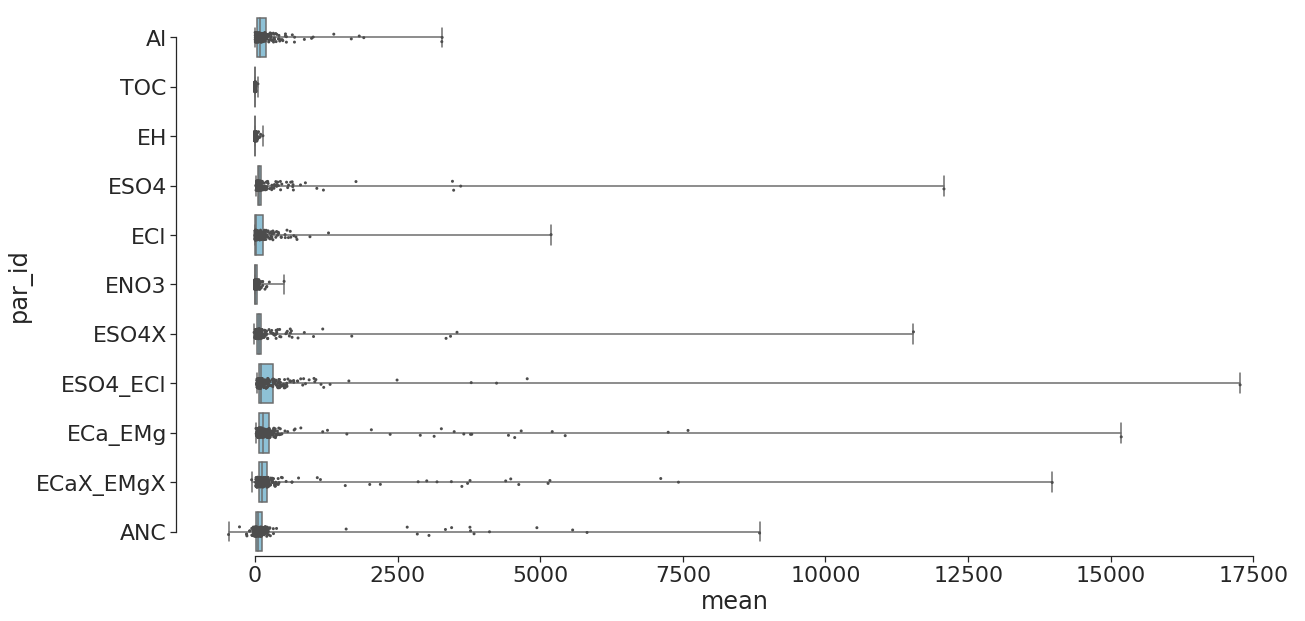

In [10]:
# Set up plot
fig = plt.figure(figsize=(20,10))
sn.set(style="ticks", palette="muted", 
       color_codes=True, font_scale=2)

# Horizontal boxplots
ax = sn.boxplot(x="mean", y="par_id", data=res_df,
                whis=np.inf, color="c")

# Add "raw" data points for each observation, with some "jitter"
# to make them visible
sn.stripplot(x="mean", y="par_id", data=res_df, jitter=True, 
             size=3, color=".3", linewidth=0)

# Remove axis lines
sn.despine(trim=True)

## 4. Data restructuring

The code below is taken from [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_oct_2016_part2.ipynb#7.-Data-restructuring). It is used to generate output files in the format requested by Heleen.

### 4.1. Combine datasets

In [11]:
# Change 'period' col to 'data_period' and add 'analysis_period'
res_df['data_period'] = res_df['period']
del res_df['period']

res_df['analysis_period'] = '1990-2016'

# Join
df = pd.merge(res_df, stn_df, how='left', on='station_id')

# Re-order columns
df = df[['station_id', 
         'station_code', 'station_name', 
         'latitude', 'longitude', 'analysis_period', 'data_period', 
         'par_id', 'non_missing', 'n_start', 'n_end', 'mean', 'median', 
         'std_dev', 'mk_stat', 'norm_mk_stat', 'mk_p_val', 'trend',
         'sen_slp']]

df.head()

,station_id,station_code,station_name,latitude,longitude,analysis_period,data_period,par_id,non_missing,n_start,n_end,mean,median,std_dev,mk_stat,norm_mk_stat,mk_p_val,trend,sen_slp
0,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,Al,1,0,0,383.392409,383.392409,NaN,NaN,NaN,NaN,NaN,NaN
1,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,TOC,27,5,5,10.930741,11.200000,1.172784,107.0,2.214912,2.676609e-02,increasing,0.055556
2,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,EH,27,5,5,10.163628,10.000000,2.511132,-120.0,-2.483843,1.299732e-02,decreasing,-0.153421
3,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,ESO4,27,5,5,30.461034,24.166667,15.724514,-306.0,-6.359690,2.021618e-10,decreasing,-1.739583
4,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,ECl,27,5,5,13.823280,12.857143,2.809527,-163.0,-3.421093,6.236991e-04,decreasing,-0.190476


### 7.2. Check record completeness

See e-mail from Heleen received 25/10/2016 at 15:56. The `'non_missing'` threshold is based of 65% of the data period (e.g. 65% of 27 years for 1990 to 2016).

In [12]:
def include(row):
    if ((row['analysis_period'] == '1990-2016') & 
        (row['n_start'] >= 2) &
        (row['n_end'] >= 2) &
        (row['non_missing'] >= 18)):
        return 'yes'
    elif ((row['analysis_period'] == '1990-2004') & 
          (row['n_start'] >= 2) &
          (row['n_end'] >= 2) &          
          (row['non_missing'] >= 10)):
        return 'yes'
    elif ((row['analysis_period'] == '2002-2016') & 
          (row['n_start'] >= 2) &
          (row['n_end'] >= 2) &          
          (row['non_missing'] >= 10)):
        return 'yes'
    else:
        return 'no'

df['include'] = df.apply(include, axis=1)

### 4.3. SO4 at Abiskojaure

SO4 for this station (`'station_id=36458'` in the "core" dataset) should be removed. See [here](https://nbviewer.jupyter.org/github/JamesSample/icpw/blob/master/toc_trends_oct_2016_part3.ipynb#1.3.-SO4-for-station-ID-36561).

In [13]:
# Remove sulphate-related series at Abiskojaure
df = df.query('not((station_id==36458) and ((par_id=="ESO4") or '
                                           '(par_id=="ESO4X") or '
                                           '(par_id=="ESO4_ECl")))')

### 7.4. Relative slope

In [14]:
# Relative slope
df['rel_sen_slp'] = df['sen_slp'] / df['median'] 

### 7.5. Tidy

In [15]:
# Remove unwanted cols
df.drop(labels=['mean', 'n_end', 'n_start', 'mk_stat', 'norm_mk_stat'],
        axis=1, inplace=True)

# Reorder columns
df = df[['station_id', 'station_code', 
         'station_name', 'latitude', 'longitude', 'analysis_period',
         'data_period', 'par_id', 'non_missing', 'median', 'std_dev',
         'mk_p_val', 'trend', 'sen_slp', 'rel_sen_slp', 'include']]

# Write to output
out_path = os.path.join(res_fold, 'toc_core_trends_long_format.csv')
df.to_csv(out_path, index=False, encoding='utf-8')

df.head()

,station_id,station_code,station_name,latitude,longitude,analysis_period,data_period,par_id,non_missing,median,std_dev,mk_p_val,trend,sen_slp,rel_sen_slp,include
0,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,Al,1,383.392409,NaN,NaN,NaN,NaN,NaN,no
1,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,TOC,27,11.200000,1.172784,2.676609e-02,increasing,0.055556,0.004960,yes
2,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,EH,27,10.000000,2.511132,1.299732e-02,decreasing,-0.153421,-0.015342,yes
3,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,ESO4,27,24.166667,15.724514,2.021618e-10,decreasing,-1.739583,-0.071983,yes
4,108,LAE01,"Langtjern, utlÃ¸p",60.37246,9.72666,1990-2016,1990-2016,ECl,27,12.857143,2.809527,6.236991e-04,decreasing,-0.190476,-0.014815,yes


### 7.6. Convert to "wide" format

In [16]:
del df['data_period']

# Melt to "long" format
melt_df = pd.melt(df, 
                  id_vars=['station_id', 'station_code', 
                           'station_name', 'latitude', 'longitude', 
                           'analysis_period', 'par_id', 'include'],
                  var_name='stat')

# Get only values where include='yes'
melt_df = melt_df.query('include == "yes"')
del melt_df['include']

# Build multi-index on everything except "value"
melt_df.set_index(['station_id', 'station_code', 
                   'station_name', 'latitude', 'longitude', 'par_id', 
                   'analysis_period', 
                   'stat'], inplace=True)

# Unstack levels of interest to columns
wide_df = melt_df.unstack(level=['par_id', 'analysis_period', 'stat'])

# Drop unwanted "value" level in index
wide_df.columns = wide_df.columns.droplevel(0)

# Replace multi-index with separate components concatenated with '_'
wide_df.columns = ["_".join(item) for item in wide_df.columns]

# Reset multiindex on rows
wide_df = wide_df.reset_index()

# Save output
out_path = os.path.join(res_fold, 'toc_trends_wide_format.csv')
wide_df.to_csv(out_path, index=False, encoding='utf-8')

wide_df.head()

,station_id,station_code,station_name,latitude,longitude,TOC_1990-2016_non_missing,EH_1990-2016_non_missing,ESO4_1990-2016_non_missing,ECl_1990-2016_non_missing,ENO3_1990-2016_non_missing,...,EH_1990-2016_rel_sen_slp,ESO4_1990-2016_rel_sen_slp,ECl_1990-2016_rel_sen_slp,ENO3_1990-2016_rel_sen_slp,ESO4X_1990-2016_rel_sen_slp,ESO4_ECl_1990-2016_rel_sen_slp,ECa_EMg_1990-2016_rel_sen_slp,ECaX_EMgX_1990-2016_rel_sen_slp,ANC_1990-2016_rel_sen_slp,Al_1990-2016_rel_sen_slp
0,108,LAE01,"Langtjern, utlÃ¸p",60.372460,9.726660,27,27,27,27,27,...,-0.0153421,-0.0719828,-0.0148148,-0.0366133,-0.0752522,-0.0537174,-0.0176009,-0.0175883,0.015666,NaN
1,221,BIE01,Birkenes,58.385426,8.241721,27,27,27,27,27,...,-0.0235381,-0.0413194,-0.00737492,-0.01,-0.0494009,-0.0203906,-0.0241935,-0.0387372,-0.197483,NaN
2,12080,STE01,Storgama v. dam,59.052333,8.653606,27,27,27,27,27,...,-0.0425499,-0.0769737,-0.0101838,-0.118056,-0.0872979,-0.0427573,-0.0167173,-0.018849,0.154454,NaN
3,12081,KAE01,KÃ¥rvatn feltforskningsstasjon,62.782883,8.893443,27,27,27,27,27,...,-0.0191471,-0.0166667,0,-0.0304348,-0.0249274,-0.00537025,0.00480173,0.00750062,0.0177619,NaN
4,12082,DALELV,Dalelv,69.684738,30.386154,27,27,27,27,27,...,-0.0250379,-0.0236446,-0.00325815,-0.0404762,-0.0277961,-0.00997677,-0.00561964,-0.00654937,0.0249325,NaN
